In [1]:
# Import all necessary packages
import torch
import torchvision.transforms as tvt
import os
import re
from PIL import Image
import matplotlib.pyplot as plt
import time
import random
from scipy.stats import wasserstein_distance

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Task 1

In [2]:
def get_images(path, resize=True, rotate=True):
    image_files = [file for file in os.listdir(path) if file != ".DS_Store"]
    image_files = [img for img in sorted(image_files, key=lambda x: int(re.sub(r'\D', '', x)))]

    images_pil = [Image.open(path + img) for img in image_files]

    if(resize):
        new_size = (300, 300)
        images_pil = [image.resize(new_size) for image in images_pil]
    images_pil_rotated = [image.rotate(270) for image in images_pil]

    return image_files, images_pil_rotated

In [3]:
def transform_tensor_to_PIL(tensor_image):
    transform = tvt.ToPILImage()
    img = transform(tensor_image)
    
    return img

In [4]:
def transform_PIL_to_tensor(image_pil):
    transform = tvt.ToTensor()
    img = transform(image_pil)

    return img

In [5]:
def create_histogram(tensor_image, bins=10):
    hist = list(map(lambda c: torch.histc(tensor_image[c,:,:], bins=bins, min=-1, max=1), list(range(3))))
    return hist

In [6]:
def compute_distance(hist1, hist2):
    distance_per_channel = list(map(lambda c: wasserstein_distance(torch.squeeze(hist1[c]).cpu().numpy(), torch.squeeze(hist2[c]).cpu().numpy()), list(range(3))))
    return distance_per_channel

In [7]:
_, images_pil = get_images("./Task 1 Images/", resize=False)

image_tensor_original = transform_PIL_to_tensor(images_pil[0])
hist_original = create_histogram(image_tensor_original, bins=10)

image_tensor_oblique = transform_PIL_to_tensor(images_pil[1])
hist_oblique = create_histogram(image_tensor_oblique, bins=10)

# Compute the distance between hist_oblique and hist_original
distance_between_original_oblique = compute_distance(hist_original, hist_oblique)
print(distance_between_original_oblique)
print(sum(distance_between_original_oblique))

[71635.99999999999, 101849.60000000002, 28705.800000000007]
202191.40000000002


In [8]:
# Perspective Transformation
endpoints = [[785, 947], [2033, 916], [2032, 1440], [789, 1474]]
startpoints = [[1530, 735], [2710, 912], [2675, 1432], [1528, 1318]]

perspective_transformed_image = tvt.functional.perspective(image_tensor_original, startpoints=startpoints, endpoints=endpoints, interpolation=tvt.InterpolationMode.BILINEAR)
hist_perspective_transformed = create_histogram(perspective_transformed_image, bins=10)

transform_tensor_to_PIL(perspective_transformed_image).save("./Task 1 Results/perspective.jpg")

# Compute the distance between hist_oblique and hist_perspective_transformed
distance_between_transformed_oblique = compute_distance(hist_perspective_transformed, hist_oblique)
print(distance_between_transformed_oblique)
print(sum(distance_between_transformed_oblique))

[63273.399999999994, 98036.00000000003, 46156.600000000006]
207466.00000000003


In [9]:
# Random Affine Transformation
random_affine_transformation = tvt.RandomAffine(degrees=(30, 70), translate=(0.2, 0.8), scale=(0.5, 0.75))

random_affine_transformed_image = random_affine_transformation(image_tensor_original)
hist_affine_transformed = create_histogram(random_affine_transformed_image, bins=10)

transform_tensor_to_PIL(random_affine_transformed_image).save("./Task 1 Results/affine.jpg")

# Compute the distance between hist_oblique and hist_affine_transformed
distance_between_transformed_oblique = compute_distance(hist_affine_transformed, hist_oblique)
print(distance_between_transformed_oblique)
print(sum(distance_between_transformed_oblique))

[958115.0, 909755.0, 904064.5999999999]
2771934.5999999996


## Task 2

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.transform = tvt.Compose([tvt.RandomAffine(degrees=(25, 45)),
                                        tvt.RandomPerspective(distortion_scale=0.6, p=0.5),
                                        tvt.ColorJitter(saturation=0.8, hue=0.2),
                                        tvt.ToTensor()])

        self.filenames, self.images = get_images(self.path)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(self.images[idx])
        label = int(self.filenames[idx].strip(".JPG"))

        return image, label
        

In [11]:
my_dataset = MyDataset("./Task 2 Images/")
print(len(my_dataset))

index = 2
print(my_dataset[index][0].shape, my_dataset[index][1])

index = 8
print(my_dataset[index][0].shape, my_dataset[index][1])

10
torch.Size([3, 300, 300]) 3
torch.Size([3, 300, 300]) 9


In [12]:
index = 2

img = transform_tensor_to_PIL(my_dataset[index][0])
img.show()

## Task 3

In [13]:
dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=4)

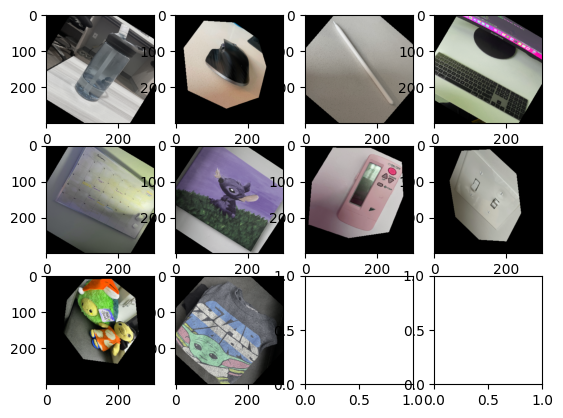

In [14]:
fig, ax = plt.subplots(3, 4)
for batch_idx, (images, labels) in enumerate(dataloader):
    for idx in range(len(labels)):
        image = transform_tensor_to_PIL(images[idx])
        ax[batch_idx, idx].imshow(image)

        label = str(labels[idx])
        image.save("./Task 3 Results/" + label + ".jpg")

In [15]:
start_time = time.time()

for idx in range(1000):
    index = random.randint(0, 9)
    augmented_image, label = my_dataset[index][0], my_dataset[index][1]

print("Runtime: %s seconds" % (time.time() - start_time))

Runtime: 18.03256607055664 seconds


In [16]:
start_time = time.time()
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=1000, shuffle=True, num_workers=4)

print("Runtime: %s seconds" % (time.time() - start_time))

Runtime: 0.00022864341735839844 seconds
